In [1]:
import numpy as np
import os
import json
import secrets
import shutil

from PIL import Image
import rosbag
import pyquaternion
import matplotlib.pyplot as plt
import glob

from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix

# import pcl
import sensor_msgs.point_cloud2 as pc2
from sensor_msgs.msg import PointCloud2
from cv_bridge import CvBridge

import struct

In [2]:
#########################################################################
# SCRIPT INPUT
dataset_root_dir = "./"
tpatches_dir = os.path.join(dataset_root_dir, "raw_data", "tangent_patches_30hz")
slam_results_dir = os.path.join(dataset_root_dir, "slam_results")
metas_path = os.path.join("../../insta360/metas/")
#########################################################################

---
### 0. finding first time-synced frame

---
### 1. Finding timstamp of first time-synced LiDAR and camera frame (from rosbag message's header.stamp), and create timestamps for the following camera and LiDAR frames.

In [3]:
best_match_lidar_idx_start = 122

# cam frame starts from 1
best_match_img_idx_start = 368 - 1 # "frame_000000368.jpg" - 1

cam_frame_rate = 30 # some scenes are 30, some are 29.97

In [4]:
########################################################
sensor_names = ["CAM_BACK", "CAM_BACK_LEFT", "CAM_FRONT_LEFT", "CAM_FRONT", "CAM_FRONT_RIGHT", "CAM_BACK_RIGHT"]

# Load images and lidar scans
cam_images = {}
for cam_idx, cam_name in enumerate(sensor_names):
    cam_images[cam_name] = sorted(glob.glob(os.path.join(dataset_root_dir, "raw_data", "tangent_patches_30hz", str(cam_idx), "*.jpg")))

lidar_scans = sorted(glob.glob(os.path.join(dataset_root_dir, "raw_data", "raw_lidar_scans_bin", "*.bin")))
########################################################

# check best match
print(f'best match lidar scan: {lidar_scans[best_match_lidar_idx_start]}')
print(f'best match image: {cam_images["CAM_FRONT"][best_match_img_idx_start]}')

best match lidar scan: ./raw_data/raw_lidar_scans_bin/1691185236.629766464.bin
best match image: ./raw_data/tangent_patches_30hz/3/frame_000000368.jpg


In [5]:
# load raw rosbag and check timestamp of best match lidar scan

########################################################
rosbag_name = "campus_usc_short_1_sync.bag"
########################################################

rosbag_path = os.path.join(dataset_root_dir, "raw_data", rosbag_name)

##### best match lidar <-> rosbag velodyne msg

In [6]:
print("start")

bag = rosbag.Bag(rosbag_path)
msg_iter = bag.read_messages(topics=['/velodyne_points']).__iter__()
msg = next(msg_iter)
for i in range(best_match_lidar_idx_start):
    msg = next(msg_iter)
    
print(msg[1].header.stamp.to_sec())
print(lidar_scans[best_match_lidar_idx_start])


start
1691185236.6297665
./raw_data/raw_lidar_scans_bin/1691185236.629766464.bin


In [7]:
# synced_cam_images, synced_lidar_scans indexing

# remove frames before best match idx
synced_lidar_scans = lidar_scans[best_match_lidar_idx_start:]
print(f'lidar: {len(synced_lidar_scans)} scans')

synced_cam_images = {}
for cam_idx, cam_name in enumerate(sensor_names):
    synced_cam_images[cam_name] = cam_images[cam_name][best_match_img_idx_start:]
    print(f'{cam_name}: {len(synced_cam_images[cam_name])} images')

lidar: 10725 scans
CAM_BACK: 32449 images
CAM_BACK_LEFT: 32449 images
CAM_FRONT_LEFT: 32449 images
CAM_FRONT: 32449 images
CAM_FRONT_RIGHT: 32449 images
CAM_BACK_RIGHT: 32449 images


In [8]:
cam_frame_num = len(synced_cam_images["CAM_FRONT"])

#####################################################################################################
# cam_fps = 29.97
cam_fps = cam_frame_rate
#####################################################################################################

# get best match lidar scan timestamp
msg_iter = bag.read_messages(topics=['/velodyne_points']).__iter__()
msg = next(msg_iter)
for i in range(best_match_lidar_idx_start):
    msg = next(msg_iter)

first_synced_frame_timestamp = msg[1].header.stamp.to_sec()

# Get lidar timestamps after first synced frame timestamp
lidar_frame_timestamps = [first_synced_frame_timestamp]
for i in range(len(synced_lidar_scans) - 1):
    msg = next(msg_iter)
    lidar_frame_timestamps.append(msg[1].header.stamp.to_sec())

# Calculate cam frame timestamps
cam_frame_timestamps = []
for i in range(cam_frame_num):
    cam_frame_timestamps.append(first_synced_frame_timestamp + i / cam_fps)

assert len(lidar_frame_timestamps) == len(synced_lidar_scans)
assert len(cam_frame_timestamps) == len(synced_cam_images["CAM_FRONT"])

# print duration
print(f'lidar duration: {lidar_frame_timestamps[-1] - lidar_frame_timestamps[0]}')
print(f'lidar fps: {len(lidar_frame_timestamps) / (lidar_frame_timestamps[-1] - lidar_frame_timestamps[0])}')

print(f'cam duration: {cam_frame_timestamps[-1] - cam_frame_timestamps[0]}')
print(f'cam fps: {len(cam_frame_timestamps) / (cam_frame_timestamps[-1] - cam_frame_timestamps[0])}')

lidar duration: 1081.6257820129395
lidar fps: 9.915629026557077
cam duration: 1081.5999999046326
cam fps: 30.000924558858276


##### Load ego pose (lidar scan rate, point-by-point rate) files

In [9]:
scan_rate_pose_file = os.path.join(slam_results_dir, "pos_lidarscan_rate.txt")
point_rate_pose_file = os.path.join(slam_results_dir, "pos_point_rate.txt")

In [ ]:
# Load ego poses
f = open(scan_rate_pose_file, 'r')
lines = f.readlines()
scan_rate_poses = []
for line in lines:
    line = line.strip()  
    line = line.split(' ')  
    
    timestamp = float(line[0])
    rotation = [float(line[1]), float(line[2]), float(line[3]), float(line[4])]
    translation = [float(line[5]), float(line[6]), float(line[7])]
    velocity = [float(line[8]), float(line[9]), float(line[10])]
    
    scan_rate_poses.append({
        "timestamp": timestamp,
        "rotation": rotation,
        "translation": translation,
        "velocity": velocity
    })
f.close()

f = open(point_rate_pose_file, 'r')
lines = f.readlines()
point_rate_poses = []
for line in lines:
    line = line.strip()  
    line = line.split(' ')  
    
    timestamp = float(line[0])
    rotation = [float(line[1]), float(line[2]), float(line[3]), float(line[4])]
    translation = [float(line[5]), float(line[6]), float(line[7])]
    velocity = [float(line[8]), float(line[9]), float(line[10])]
    
    point_rate_poses.append({
        "timestamp": timestamp,
        "rotation": rotation,
        "translation": translation,
        "velocity": velocity
    })
f.close()

##### Asign the corresponding ego poses to synced lidar and camera frames

In [11]:
# 1. Get synced lidar scan poses corresponding to synced lidar scans 

# find first synced lidar scan index in scan_rate_poses
first_synced_scan_pose_idx = None
for i in range(len(scan_rate_poses)):
    if format(scan_rate_poses[i]["timestamp"], ".4f") == format(lidar_frame_timestamps[0], ".4f"):
        first_synced_scan_pose_idx = i

if first_synced_scan_pose_idx is None:
    raise Exception("first_synced_lidar_scan_idx is None")

# synced_lidar_scan_poses = scan_rate_poses[first_synced_scan_pose_idx:]
synced_lidar_scan_poses = []
synced_posed_lidar_scans = []
synced_posed_lidar_frame_timestamps = []

# find synced lidar scan pose for each synced lidar scan
for i in range(len(synced_lidar_scans)):
    for j in range(first_synced_scan_pose_idx, len(scan_rate_poses)):
        if format(scan_rate_poses[j]["timestamp"], ".2f") == format(lidar_frame_timestamps[i], ".2f"):
            synced_lidar_scan_poses.append(scan_rate_poses[j])
            synced_posed_lidar_scans.append(synced_lidar_scans[i])
            synced_posed_lidar_frame_timestamps.append(lidar_frame_timestamps[i])
            break

synced_lidar_scans = synced_posed_lidar_scans
lidar_frame_timestamps = synced_posed_lidar_frame_timestamps

# print length
print(f'lidar scans: {len(synced_lidar_scans)}')
print(f'lidar scan poses: {len(synced_lidar_scan_poses)}')
print(f'lidar frame timestamps: {len(lidar_frame_timestamps)}\n')

assert len(synced_lidar_scan_poses) == len(synced_lidar_scans) == len(lidar_frame_timestamps)

# check
print(f'first_synced_lidar_scan: {synced_lidar_scans[0]}')
print(f'first_synced_lidar_scan_pose: {synced_lidar_scan_poses[0]["timestamp"]}')
print(f'first_synced_lidar_scan_timestamp: {lidar_frame_timestamps[0]}\n')

print(f'last_synced_lidar_scan: {synced_lidar_scans[-1]}')
print(f'last_synced_lidar_scan_pose: {synced_lidar_scan_poses[-1]["timestamp"]}')
print(f'last_synced_lidar_scan_timestamp: {lidar_frame_timestamps[-1]}')

lidar scans: 10725
lidar scan poses: 10725
lidar frame timestamps: 10725

first_synced_lidar_scan: ./raw_data/raw_lidar_scans_bin/1691185236.629766464.bin
first_synced_lidar_scan_pose: 1691185236.629766
first_synced_lidar_scan_timestamp: 1691185236.6297665

last_synced_lidar_scan: ./raw_data/raw_lidar_scans_bin/1691186318.255548477.bin
last_synced_lidar_scan_pose: 1691186318.255548
last_synced_lidar_scan_timestamp: 1691186318.2555485


In [12]:
# 2. Get synced point-rate poses or scan-rate poses corresponding to synced cam frames    
# we have point_rate_poses, scan_rate_poses, cam_frame_timestamps, synced_cam_images

# Convert point_rate_poses and scan_rate_poses to dict that has timestamp before the decimal point as key
all_poses_group_by_second = {}

for i in range(len(scan_rate_poses)):
    timestamp = scan_rate_poses[i]["timestamp"]
    timestamp_before_decimal_point = int(timestamp)
    
    if timestamp_before_decimal_point not in all_poses_group_by_second:
        all_poses_group_by_second[timestamp_before_decimal_point] = []
    
    all_poses_group_by_second[timestamp_before_decimal_point].append(scan_rate_poses[i])
    
for i in range(len(point_rate_poses)):
    timestamp = point_rate_poses[i]["timestamp"]
    timestamp_before_decimal_point = int(timestamp)
    
    if timestamp_before_decimal_point not in all_poses_group_by_second:
        all_poses_group_by_second[timestamp_before_decimal_point] = []
    
    all_poses_group_by_second[timestamp_before_decimal_point].append(point_rate_poses[i])

In [13]:
synced_cam_frame_poses = []

# find cloest pose for each cam frame in time space
# Use point_rate_poses_group_by_second to reduce time complexity
for i in range(len(synced_cam_images["CAM_FRONT"])):
    cam_img_timestamp = cam_frame_timestamps[i]
    cam_img_timestamp_before_decimal_point = int(cam_img_timestamp)
    
    point_rate_poses_in_target_second = all_poses_group_by_second[cam_img_timestamp_before_decimal_point]
    
    # find cloest pose in point_rate_poses_in_target_second
    min_diff = 1000000000
    min_diff_pose = None
    for j in range(len(point_rate_poses_in_target_second)):
        diff = abs(point_rate_poses_in_target_second[j]["timestamp"] - cam_img_timestamp)
        if diff < min_diff:
            min_diff = diff
            min_diff_pose = point_rate_poses_in_target_second[j]
    
    synced_cam_frame_poses.append({
        "cam_frame_timestamp": cam_img_timestamp,
        "point_rate_timestamp": min_diff_pose["timestamp"],
        "rotation": min_diff_pose["rotation"],
        "translation": min_diff_pose["translation"],
        "velocity": min_diff_pose["velocity"]
    })

assert len(synced_cam_frame_poses) == len(synced_cam_images["CAM_FRONT"]) == len(cam_frame_timestamps)

In [ ]:
# Now, we have 
# synced_cam_images, cam_frame_timestamps, synced_cam_frame_poses
# synced_lidar_scans, lidar_frame_timestamps, synced_lidar_scan_poses

---

### 2. Matching between Time-synced, pose-labeled camera frames and lidar scans

In [ ]:
closest_cam_frame_idx = []
for i in range(len(synced_lidar_scan_poses)):
    min_diff = 1000000000
    min_diff_cam_frame_idx = None
    for j in range(len(synced_cam_frame_poses)):
        diff = abs(synced_lidar_scan_poses[i]["timestamp"] - synced_cam_frame_poses[j]["point_rate_timestamp"])
        if diff < min_diff:
            min_diff = diff
            min_diff_cam_frame_idx = j
    
    closest_cam_frame_idx.append(min_diff_cam_frame_idx)

assert len(closest_cam_frame_idx) == len(synced_lidar_scan_poses) == len(synced_lidar_scans)

In [27]:
# Now, we have 
# cam-related:   synced_cam_images, cam_frame_timestamps, synced_cam_frame_poses
# lidar-related: synced_lidar_scans, lidar_frame_timestamps, synced_lidar_scan_poses, closest_cam_frame_idx

In [15]:
# Collect all data related to cam frames
sensor_names = ["CAM_BACK", "CAM_BACK_LEFT", "CAM_FRONT_LEFT", "CAM_FRONT", "CAM_FRONT_RIGHT", "CAM_BACK_RIGHT"]

cam_sample_data = []
filtered_cam_frame_num = 0
for i in range(len(cam_frame_timestamps)):
    
    if abs(cam_frame_timestamps[i] - synced_cam_frame_poses[i]["point_rate_timestamp"]) > 0.01: 
        filtered_cam_frame_num += 1
        continue
        
    cam_sample_data.append({
        "cam_timestamp": cam_frame_timestamps[i],
        "ego_pose": synced_cam_frame_poses[i],
        "cam_images": {
            "CAM_BACK": synced_cam_images["CAM_BACK"][i],
            "CAM_BACK_LEFT": synced_cam_images["CAM_BACK_LEFT"][i],
            "CAM_FRONT_LEFT": synced_cam_images["CAM_FRONT_LEFT"][i],
            "CAM_FRONT": synced_cam_images["CAM_FRONT"][i],
            "CAM_FRONT_RIGHT": synced_cam_images["CAM_FRONT_RIGHT"][i],
            "CAM_BACK_RIGHT": synced_cam_images["CAM_BACK_RIGHT"][i],
        }
    })
    
    # for cam_name in sensor_names:
    #     cam_sample_data[i]["cam_images"][cam_name] = synced_cam_images[cam_name][i]
        
# Check there are no duplicated ego pose timestamps between last adjacent cam frames
print(f'filtered_cam_frame_num: {filtered_cam_frame_num}')
assert cam_sample_data[-1]["ego_pose"]["point_rate_timestamp"] != cam_sample_data[-2]["ego_pose"]["point_rate_timestamp"]


# Collect all data related to LiDAR frames except for the frame that has filtered cam frame
lidar_sample_data = []
for i in range(len(synced_lidar_scans)):
    
    # if current closest cam frame idx is larger than the length of cam_sample_data, skip
    if closest_cam_frame_idx[i] >= len(cam_sample_data):
        continue
    
    lidar_sample_data.append({
        "lidar_path": synced_lidar_scans[i],
        "lidar_timestamp": lidar_frame_timestamps[i],
        "ego_pose": synced_lidar_scan_poses[i],
        "closest_cam_frame_idx": closest_cam_frame_idx[i],
    })

filtered_cam_frame_num: 3


---

### 3. 3D-2D projection alignment visualization

In [ ]:
# Now, we have
# lidar_sample_data, cam_sample_data

In [16]:
def get_sensor_calib(cam_name):
    with open(os.path.join(metas_path, "calibrated_sensor.json")) as f:
        calib_sensors = json.load(f)

    with open(os.path.join(metas_path, "sensor.json")) as f:
        sensors = json.load(f)    
        
    for sensor in sensors:
        if sensor['channel'] == cam_name:
            sensor_token = sensor['token']
            break
    
    for calib_sensor in calib_sensors:
        if calib_sensor['sensor_token'] == sensor_token:
            sensor_calib = calib_sensor
            break
    
    return sensor_calib

In [ ]:
def vis_3Dto2D_all_cam_with_egomotion(cam_sample, lidar_sample):
    lidar_path = lidar_sample["lidar_path"]
    
    cam_names = ["CAM_BACK", "CAM_BACK_LEFT", "CAM_FRONT_LEFT", "CAM_FRONT", "CAM_FRONT_RIGHT", "CAM_BACK_RIGHT"]
    
    for cam_idx, cam_name in enumerate(cam_names):
        img_path = cam_sample["cam_images"][cam_name]
        im = Image.open(img_path)
        
        scan = np.fromfile(lidar_path, dtype=np.float32)
        points = scan.reshape((-1, 4))[:, :4] # VLP16은 (x, y, z, intensity) - no ring index
        pc = LidarPointCloud(points.T)
        
        calib_sensor = get_sensor_calib(cam_name)
        
        # lidar2imu_translation = np.array([0.031, 0.0, -0.0389])
        # lidar2imu_rotation = pyquaternion.Quaternion([1.0, 0.0, 0.0, 0.0]).rotation_matrix
        # pc.rotate(lidar2imu_rotation)
        # pc.translate(lidar2imu_translation)
        
        ##########################################################
        # Second step: transform from ego to the global frame.
        lidar_ego2global_translation = np.array(lidar_sample["ego_pose"]["translation"])
        lidar_ego2global_rotation = pyquaternion.Quaternion(lidar_sample["ego_pose"]["rotation"]).rotation_matrix 

        pc.rotate(lidar_ego2global_rotation)
        pc.translate(lidar_ego2global_translation)

        # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
        cam_ego2global_translation = np.array(cam_sample["ego_pose"]["translation"])
        cam_ego2global_rotation = pyquaternion.Quaternion(cam_sample["ego_pose"]["rotation"]).rotation_matrix

        pc.translate(-cam_ego2global_translation)
        pc.rotate(cam_ego2global_rotation.T)
        ##########################################################
        
        # Fourth step: transform from ego (lidar) into the camera.
        #   1. transform from ego (lidar) into the imu
        lidar2imu_translation = np.array([0.031, 0.0, -0.0389])
        lidar2imu_rotation = pyquaternion.Quaternion([1.0, 0.0, 0.0, 0.0]).rotation_matrix
        pc.rotate(lidar2imu_rotation)
        pc.translate(lidar2imu_translation)
        
        #   2. transform from imu into the sensor
        sensor2imu_translation = np.array(calib_sensor['translation'])
        sensor2imu_rotation = pyquaternion.Quaternion(calib_sensor['rotation']).rotation_matrix
        imu2sensor_translation = -sensor2imu_translation
        imu2sensor_rotation = sensor2imu_rotation.T
        pc.rotate(imu2sensor_rotation)
        pc.translate(imu2sensor_translation)
        
        # Fifth step: actually take a "picture" of the point cloud.
        # Grab the depths (camera frame z axis points away from the camera).
        depths = pc.points[2, :]
        coloring = depths
        # Take the actual picture (matrix multiplication with camera-matrix + renormalization).
        cam_intrinsic = np.array(calib_sensor['camera_intrinsic'])
        points = view_points(pc.points[:3, :], cam_intrinsic, normalize=True)
        
        min_dist = 1.0
        mask = np.ones(depths.shape[0], dtype=bool)
        mask = np.logical_and(mask, depths > min_dist)
        mask = np.logical_and(mask, points[0, :] > 1)
        mask = np.logical_and(mask, points[0, :] < im.size[0] - 1)
        mask = np.logical_and(mask, points[1, :] > 1)
        mask = np.logical_and(mask, points[1, :] < im.size[1] - 1)
        points = points[:, mask]
        coloring = coloring[mask]
        dot_size = 5
        
        fig, ax = plt.subplots(1, 1, figsize=(9, 16))
        fig.canvas.set_window_title('first frame')
        
        title = cam_name + " ", str(abs(cam_sample["cam_timestamp"] - lidar_sample["lidar_timestamp"]))
        ax.set_title(title)
        ax.imshow(im)
        ax.scatter(points[0, :], points[1, :], c=coloring, s=dot_size)
        ax.axis('off')
        plt.show()

31595


/tmp/ipykernel_69527/1983253459.py:75: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use `.FigureManagerBase.set_window_title` or GUI-specific methods instead.
  fig.canvas.set_window_title('first frame')


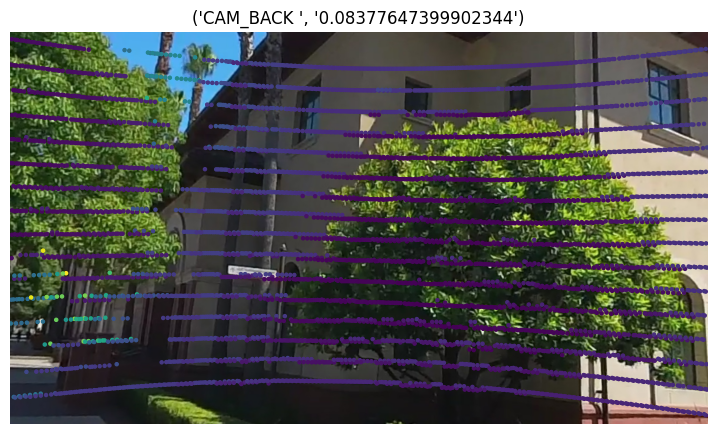

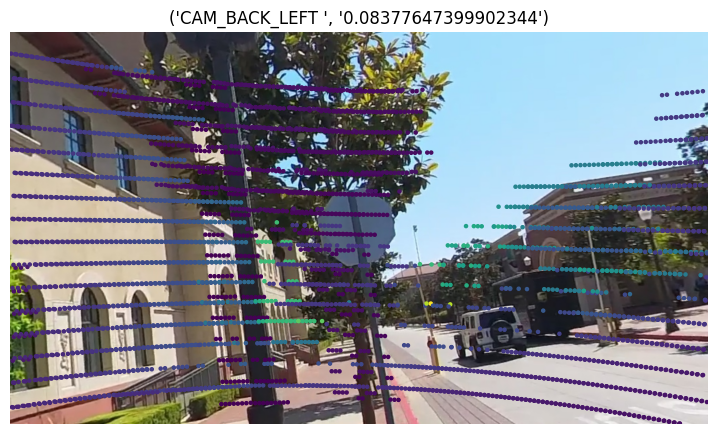

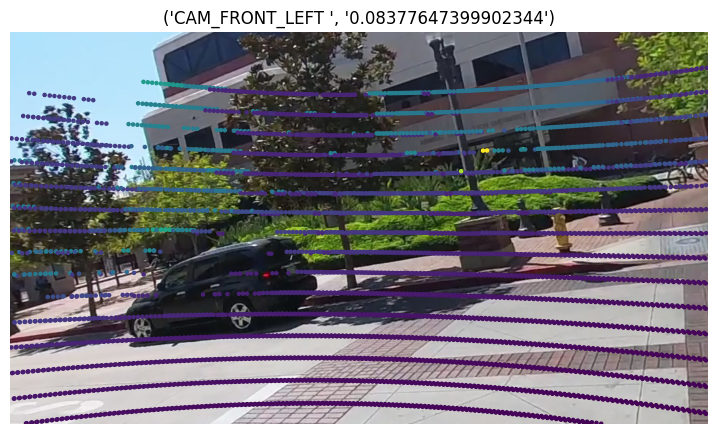

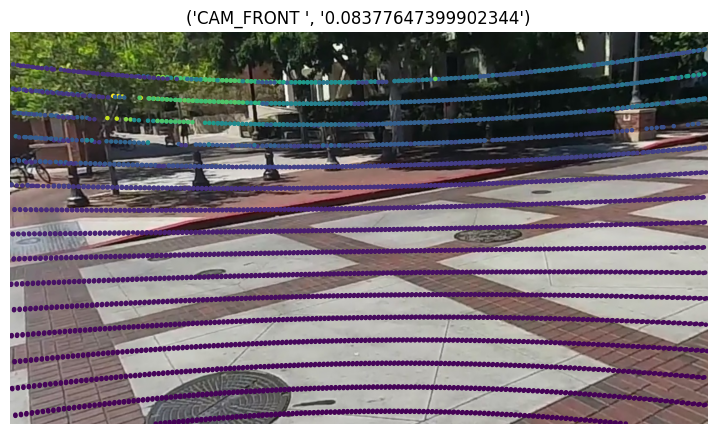

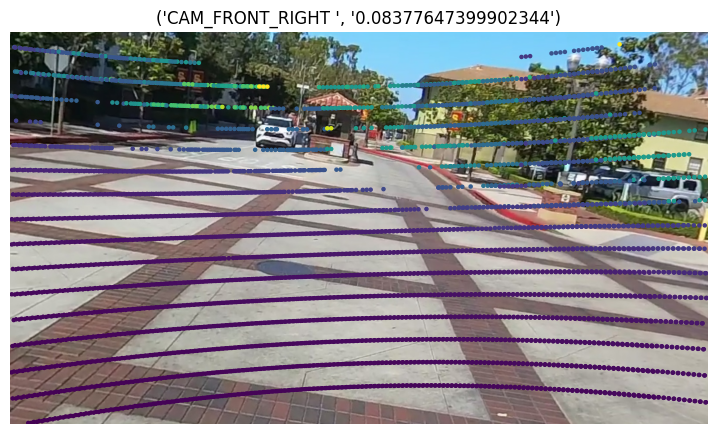

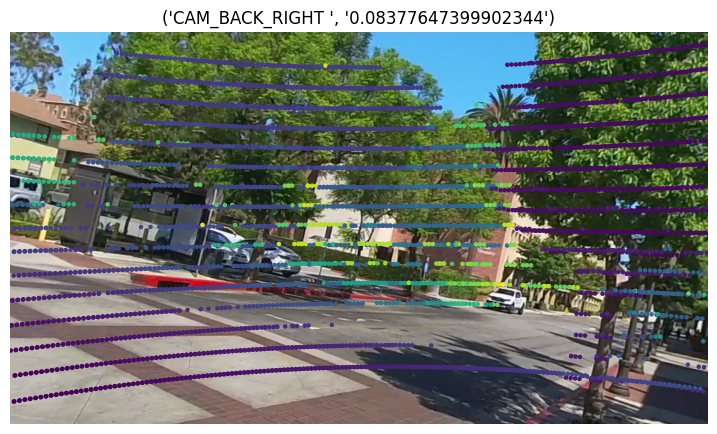

In [28]:
index = 10442

lidar_sample = lidar_sample_data[index]
cam_sample = cam_sample_data[lidar_sample["closest_cam_frame_idx"]]

print(lidar_sample["closest_cam_frame_idx"])

vis_3Dto2D_all_cam_with_egomotion(cam_sample, lidar_sample)

---

### 5. Nusc format dataset generation

In [29]:
scene_token = secrets.token_hex(16)

scene_name = "campus_usc_short_1"
scene_desc = ""
date_captured = "2023-08-04"
location = "los angeles"

tpatch_height = 900
tpatch_width = 1600

##### Create nusc-related folders

In [30]:
sensor_names = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']

# Move downsampled sensor data to nusc samples folder
# Create nusc folders
nusc_path = os.path.join(dataset_root_dir, 'nusc')
os.mkdir(nusc_path)

# samples
os.mkdir(os.path.join(nusc_path, 'samples'))
for sensor_name in sensor_names:
    os.mkdir(os.path.join(nusc_path, 'samples', sensor_name))
os.mkdir(os.path.join(nusc_path, 'samples', "LIDAR_TOP"))

# sweeps
os.mkdir(os.path.join(nusc_path, 'sweeps'))
for sensor_name in sensor_names:
    os.mkdir(os.path.join(nusc_path, 'sweeps', sensor_name))
os.mkdir(os.path.join(nusc_path, 'sweeps', "LIDAR_TOP"))

# trainval
trainval_path = os.path.join(nusc_path, 'v1.0-trainval')
os.mkdir(trainval_path)

##### (2) Generate ego_pose.json

In [ ]:
# Now, we have
# cam_sample_data, lidar_sample_data

In [31]:
# Generate all ego pose tokens for each cam frame and lidar frame
for cam_sample in cam_sample_data:
    cam_sample["ego_pose"]['ego_pose_token'] = secrets.token_hex(16)

for lidar_sample in lidar_sample_data:
    lidar_sample["ego_pose"]['ego_pose_token'] = secrets.token_hex(16)

ego_poses = []

for cam_sample in cam_sample_data:
    ego_pose = {
        "token": cam_sample["ego_pose"]['ego_pose_token'],
        "timestamp": cam_sample["ego_pose"]["point_rate_timestamp"],
        "rotation": cam_sample["ego_pose"]["rotation"],
        "translation": cam_sample["ego_pose"]["translation"],
        "velocity": cam_sample["ego_pose"]["velocity"]
    }
    ego_poses.append(ego_pose)

for lidar_sample in lidar_sample_data:
    ego_pose = {
        "token": lidar_sample["ego_pose"]['ego_pose_token'],
        "timestamp": lidar_sample["ego_pose"]["timestamp"],
        "rotation": lidar_sample["ego_pose"]["rotation"],
        "translation": lidar_sample["ego_pose"]["translation"],
        "velocity": lidar_sample["ego_pose"]["velocity"]
    }
    ego_poses.append(ego_pose)

assert len(ego_poses) == len(cam_sample_data) + len(lidar_sample_data)

with open(os.path.join(trainval_path + "/" + "ego_pose.json"), "w") as json_file:
    json.dump(ego_poses, json_file, indent=0)

##### (3) samples.json

In [32]:
samples = []

# First time-synced frame is always keyframe
sample_token = secrets.token_hex(16)
lidar_sample_data[0]["is_key_frame"] = True
lidar_sample_data[0]["sample_token"] = sample_token
cam_sample_data[lidar_sample_data[0]["closest_cam_frame_idx"]]["is_key_frame"] = True
cam_sample_data[lidar_sample_data[0]["closest_cam_frame_idx"]]["sample_token"] = sample_token

samples.append({ # first sample
    "token": sample_token,
    "timestamp": lidar_sample_data[0]["lidar_timestamp"],
    "scene_token": scene_token,
    "prev": "",
    "next": "", # Need to be added
})

# Make 20hz -> 2hz downsampled lidar frame and the corresponding cam frame as keyframe
downsampled_lidar_timestamps = []
downsampled_lidar_timestamps.append(lidar_sample_data[0]["lidar_timestamp"])
for i in range(1, len(lidar_sample_data)):
    if lidar_sample_data[i]["lidar_timestamp"] - downsampled_lidar_timestamps[-1] >= 0.5:
        downsampled_lidar_timestamps.append(lidar_sample_data[i]["lidar_timestamp"])
        
        sample_token = secrets.token_hex(16)
        lidar_sample_data[i]["is_key_frame"] = True
        lidar_sample_data[i]["sample_token"] = sample_token
        cam_sample_data[lidar_sample_data[i]["closest_cam_frame_idx"]]["is_key_frame"] = True
        cam_sample_data[lidar_sample_data[i]["closest_cam_frame_idx"]]["sample_token"] = sample_token
        
        samples[-1]["next"] = sample_token
        samples.append({
            "token": sample_token,
            "timestamp": lidar_sample_data[i]["lidar_timestamp"],
            "scene_token": scene_token,
            "prev": samples[-1]["token"],
            "next": "",
        })

assert len(samples) == len(downsampled_lidar_timestamps)

# print raw lidar fps and downsampled lidar fps
print(f'raw lidar fps: {len(lidar_sample_data) / (lidar_sample_data[-1]["lidar_timestamp"] - lidar_sample_data[0]["lidar_timestamp"])}')
print(f'downsampled lidar fps: {len(downsampled_lidar_timestamps) / (downsampled_lidar_timestamps[-1] - downsampled_lidar_timestamps[0])}')

# check prev and next relationships
prev_token = None
for sample in samples:
    if prev_token is not None:
        assert sample["prev"] == prev_token
    prev_token = sample["token"]

with open(os.path.join(trainval_path + "/" + "sample.json"), "w") as json_file:
    json.dump(samples, json_file, indent=0)

raw lidar fps: 9.915631204819572
downsampled lidar fps: 1.9825714168733715


##### Copy samples (keyframe) and sweeps (non-keyframe) to nusc folder

In [33]:
# Copy cam sample data to nusc samples and sweeps folder
for cam_sample in cam_sample_data:
    cam_sample['nusc_fnames'] = {}
    
    for cam_name in sensor_names:
        img_path = cam_sample["cam_images"][cam_name]
        basename = os.path.basename(img_path)
        img_name= f"{scene_name}_{date_captured}_{basename.replace('.jpg', '')}_{cam_name}_{str(cam_sample['cam_timestamp']).replace('.', '_')}.jpg"
        src_path = img_path

        if "is_key_frame" in cam_sample and cam_sample['is_key_frame']:        
            nusc_fname = os.path.join('samples', cam_name, img_name)
        else:
            nusc_fname = os.path.join('sweeps', cam_name, img_name)

        cam_sample['nusc_fnames'][cam_name] = nusc_fname

        dst_path = os.path.join(nusc_path, nusc_fname)
        shutil.copyfile(src_path, dst_path)

# Print
for sensor_name in sensor_names:
    images = glob.glob(os.path.join(nusc_path, 'samples', sensor_name, '*.jpg'))
    print(f'{sensor_name}: {len(images)} sample images')
for sensor_name in sensor_names:
    images = glob.glob(os.path.join(nusc_path, 'sweeps', sensor_name, '*.jpg'))
    print(f'{sensor_name}: {len(images)} sweep images')

# Copy lidar sample data to nusc samples folder
for lidar_sample in lidar_sample_data:
    lidar_path = lidar_sample["lidar_path"]
    
    basename = os.path.basename(lidar_path)
    basename = basename.replace('.bin', '')
    basename = basename.replace('.', '_')
    
    lidar_name = f"{scene_name}_{date_captured}_LIDAR_TOP_{basename}.bin"
    src_path = lidar_path
    
    if "is_key_frame" in lidar_sample and lidar_sample['is_key_frame']:
        nusc_fname = os.path.join('samples', 'LIDAR_TOP', lidar_name)
    else:
        nusc_fname = os.path.join('sweeps', 'LIDAR_TOP', lidar_name)
    
    lidar_sample['nusc_fname'] = nusc_fname
    
    dst_path = os.path.join(nusc_path, nusc_fname)
    shutil.copyfile(src_path, dst_path)

# print
print(f'samples LIDAR_TOP: {len(glob.glob(os.path.join(nusc_path, "samples", "LIDAR_TOP", "*.bin")))} scans')
print(f'sweeps LIDAR_TOP: {len(glob.glob(os.path.join(nusc_path, "sweeps", "LIDAR_TOP", "*.bin")))} scans')

assert len(glob.glob(os.path.join(nusc_path, 'samples', 'LIDAR_TOP', '*.bin'))) + len(glob.glob(os.path.join(nusc_path, 'sweeps', 'LIDAR_TOP', '*.bin'))) \
    == len(lidar_sample_data)

CAM_FRONT_LEFT: 2144 sample images
CAM_FRONT: 2144 sample images
CAM_FRONT_RIGHT: 2144 sample images
CAM_BACK_LEFT: 2144 sample images
CAM_BACK: 2144 sample images
CAM_BACK_RIGHT: 2144 sample images
CAM_FRONT_LEFT: 30302 sweep images
CAM_FRONT: 30302 sweep images
CAM_FRONT_RIGHT: 30302 sweep images
CAM_BACK_LEFT: 30302 sweep images
CAM_BACK: 30302 sweep images
CAM_BACK_RIGHT: 30302 sweep images
samples LIDAR_TOP: 2144 scans
sweeps LIDAR_TOP: 8579 scans


##### sample_data.json

In [34]:
# Calibrated sensor tokens
calibrated_sensor_tokens = {
    "CAM_BACK": "9452428b74ab49d590ae3d239b5aaf92",
    "CAM_BACK_LEFT": "e2d13d86595a406388bdaea248c05402",
    "CAM_FRONT_LEFT": "e2fb0afdce5949709f0184f6c9a17be1",
    "CAM_FRONT": "2e64b091b3b146a390c2606b9081343c",
    "CAM_FRONT_RIGHT": "6912f92757b1426bb2ead18b6b6e8981",
    "CAM_BACK_RIGHT": "76e9065936cf461db308674f312bc107",
    "LIDAR_TOP": "c834fd2405097519c83407bd62e396b4"
}

sample_data = []

# make tokens for lidar sample data
for lidar_data in lidar_sample_data:
    lidar_data["token"] = secrets.token_hex(16)

for idx, lidar_data in enumerate(lidar_sample_data):
    token = lidar_data["token"]
    
    if "is_key_frame" in lidar_data and lidar_data["is_key_frame"]:
        sample_token = lidar_data["sample_token"]
    else: # find keyframe which is closest to the current lidar frame in time
        min_diff = 1000000000
        min_diff_key_frame_idx = None
        # range near the current lidar frame (+- 300) to reduce time complexity
        for i in range(max(0, idx - 300), min(len(lidar_sample_data), idx + 300)):
            if "is_key_frame" in lidar_sample_data[i] and lidar_sample_data[i]["is_key_frame"]:
                diff = abs(lidar_sample_data[i]["lidar_timestamp"] - lidar_data["lidar_timestamp"])
                if diff < min_diff:
                    min_diff = diff
                    min_diff_key_frame_idx = i
        sample_token = lidar_sample_data[min_diff_key_frame_idx]["sample_token"]
    
    ego_pose_token = lidar_data["ego_pose"]["ego_pose_token"]
    calibrated_sensor_token = calibrated_sensor_tokens["LIDAR_TOP"]
    timestamp = lidar_data["lidar_timestamp"]
    fileformat = "pcd"
    is_key_frame = lidar_data["is_key_frame"] if "is_key_frame" in lidar_data else False
    height = 0
    width = 0
    filename = lidar_data["nusc_fname"]
    prev = lidar_sample_data[idx - 1]["token"] if idx > 0 else ""
    next = lidar_sample_data[idx + 1]["token"] if idx < len(lidar_sample_data) - 1 else ""
    
    sample_data.append({
        "token": token,
        "sample_token": sample_token,
        "ego_pose_token": ego_pose_token,
        "calibrated_sensor_token": calibrated_sensor_token,
        "timestamp": timestamp,
        "fileformat": fileformat,
        "is_key_frame": is_key_frame,
        "height": height,
        "width": width,
        "filename": filename,
        "prev": prev,
        "next": next
    })

assert len(sample_data) == len(lidar_sample_data)

# make tokens for cam sample data
for cam_sample in cam_sample_data:
    cam_sample['sample_data_tokens'] = {}
    for cam_name in sensor_names:
        cam_sample['sample_data_tokens'][cam_name] = secrets.token_hex(16)
     
for cam_idx, cam_sample in enumerate(cam_sample_data):
    for cam_name in sensor_names:
        token = cam_sample['sample_data_tokens'][cam_name]
        
        if "is_key_frame" in cam_sample and cam_sample["is_key_frame"]:
            sample_token = cam_sample["sample_token"]
        else: # find keyframe which is closest to the current cam frame in time
            min_diff = 1000000000
            min_diff_key_frame_idx = None
            # range near the current cam frame (+- 300) to reduce time complexity
            for i in range(max(0, cam_idx - 300), min(len(cam_sample_data), cam_idx + 300)):
                if "is_key_frame" in cam_sample_data[i] and cam_sample_data[i]["is_key_frame"]:
                    diff = abs(cam_sample_data[i]["cam_timestamp"] - cam_sample["cam_timestamp"])
                    if diff < min_diff:
                        min_diff = diff
                        min_diff_key_frame_idx = i
            sample_token = cam_sample_data[min_diff_key_frame_idx]["sample_token"]
        
        ego_pose_token = cam_sample["ego_pose"]["ego_pose_token"]
        calibrated_sensor_token = calibrated_sensor_tokens[cam_name]
        timestamp = cam_sample["cam_timestamp"]
        fileformat = "jpg"
        is_key_frame = cam_sample["is_key_frame"] if "is_key_frame" in cam_sample else False
        height = tpatch_height
        width = tpatch_width
        filename = cam_sample['nusc_fnames'][cam_name]
        prev = cam_sample_data[cam_idx - 1]['sample_data_tokens'][cam_name] if cam_idx > 0 else ""
        next = cam_sample_data[cam_idx + 1]['sample_data_tokens'][cam_name] if cam_idx < len(cam_sample_data) - 1 else ""
        
        sample_data.append({
            "token": token,
            "sample_token": sample_token,
            "ego_pose_token": ego_pose_token,
            "calibrated_sensor_token": calibrated_sensor_token,
            "timestamp": timestamp,
            "fileformat": fileformat,
            "is_key_frame": is_key_frame,
            "height": height,
            "width": width,
            "filename": filename,
            "prev": prev,
            "next": next
        })

assert len(sample_data) == len(lidar_sample_data) + len(cam_sample_data * len(sensor_names))

with open(os.path.join(trainval_path + "/" + "sample_data.json"), "w") as json_file:
    json.dump(sample_data, json_file, indent=0)

In [35]:
log_token = secrets.token_hex(16)

log = {
    "token": log_token,
    "logfile": "",
    "vehicle": "",
    "date_captured": date_captured,
    "location": location
}

scene = {
    "token": scene_token,
    "log_token": log_token,
    "nbr_samples": len(samples),
    "first_sample_token": samples[0]['token'],
    "last_sample_token": samples[-1]['token'],
    "name": scene_name,
    "description": scene_desc
}

map = {
    "category": "semantic_prior",
    "token": secrets.token_hex(16),
    "filename": "",
    "log_tokens": [log_token],
}

with open(os.path.join(trainval_path + "/" + "log.json"), "w") as json_file:
    json.dump(log, json_file, indent=0)

with open(os.path.join(trainval_path + "/" + "scene.json"), "w") as json_file:
    json.dump(scene, json_file, indent=0)

with open(os.path.join(trainval_path + "/" + "map.json"), "w") as json_file:
    json.dump(map, json_file, indent=0)

In [36]:
# copy all common json files from metas folder to nusc folder
metas = glob.glob(os.path.join(metas_path, '*.json'))
for meta in metas:
    shutil.copyfile(meta, os.path.join(trainval_path, os.path.basename(meta)))

---

### 6. IMU sample data

In [37]:
rosbag_path = os.path.join(dataset_root_dir, "raw_data", rosbag_name)

bag = rosbag.Bag(rosbag_path)
msg_iter = bag.read_messages(topics=['/imu/data']).__iter__()

# msg = next(msg_iter)
msg = msg_iter.__next__()

# find imu data right after the first cam sample data
while(msg[1].header.stamp.to_sec() < cam_sample_data[0]["cam_timestamp"]):
    # msg = next(msg_iter)
    msg = msg_iter.__next__()

imu_msg = [msg]
# Get imu data right before the last cam sample data
while(True):
    # msg = next(msg_iter)
    msg = msg_iter.__next__()
    if msg[1].header.stamp.to_sec() >= cam_sample_data[-1]["cam_timestamp"]:
        break
    imu_msg.append(msg)

assert imu_msg[0][1].header.stamp.to_sec() > cam_sample_data[0]["cam_timestamp"]
assert imu_msg[-1][1].header.stamp.to_sec() < cam_sample_data[-1]["cam_timestamp"]

imu_sample_data = []
for i in range(len(imu_msg)):
    
    orientation = [imu_msg[i][1].orientation.w, imu_msg[i][1].orientation.x, imu_msg[i][1].orientation.y, imu_msg[i][1].orientation.z]
    orientation_cov = imu_msg[i][1].orientation_covariance
    angular_velocity = [imu_msg[i][1].angular_velocity.x, imu_msg[i][1].angular_velocity.y, imu_msg[i][1].angular_velocity.z]
    angular_velocity_cov = imu_msg[i][1].angular_velocity_covariance
    linear_acceleration = [imu_msg[i][1].linear_acceleration.x, imu_msg[i][1].linear_acceleration.y, imu_msg[i][1].linear_acceleration.z]
    linear_acceleration_cov = imu_msg[i][1].linear_acceleration_covariance
    
    imu_sample_data.append({
        "timestamp": imu_msg[i][1].header.stamp.to_sec(),
        "orientation": orientation,
        "orientation_cov": orientation_cov,
        "angular_velocity": angular_velocity,
        "angular_velocity_cov": angular_velocity_cov,
        "linear_acceleration": linear_acceleration,
        "linear_acceleration_cov": linear_acceleration_cov
    })

assert len(imu_sample_data) == len(imu_msg)

with open(os.path.join(trainval_path + "/" + "imu_data.json"), "w") as json_file:
    json.dump(imu_sample_data, json_file, indent=0)

---